In [1]:
import os
import json

import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

import wandb
from wandb.keras import WandbCallback

%matplotlib notebook

In [2]:
# load the data

file_name = "polynome_ready_for_training.json"

with open(file_name, "r") as f:
    data = json.load(f)
    
print("keys: ", list(data.keys()))

keys:  ['states', 'actions', 'scores']


<IPython.core.display.Javascript object>


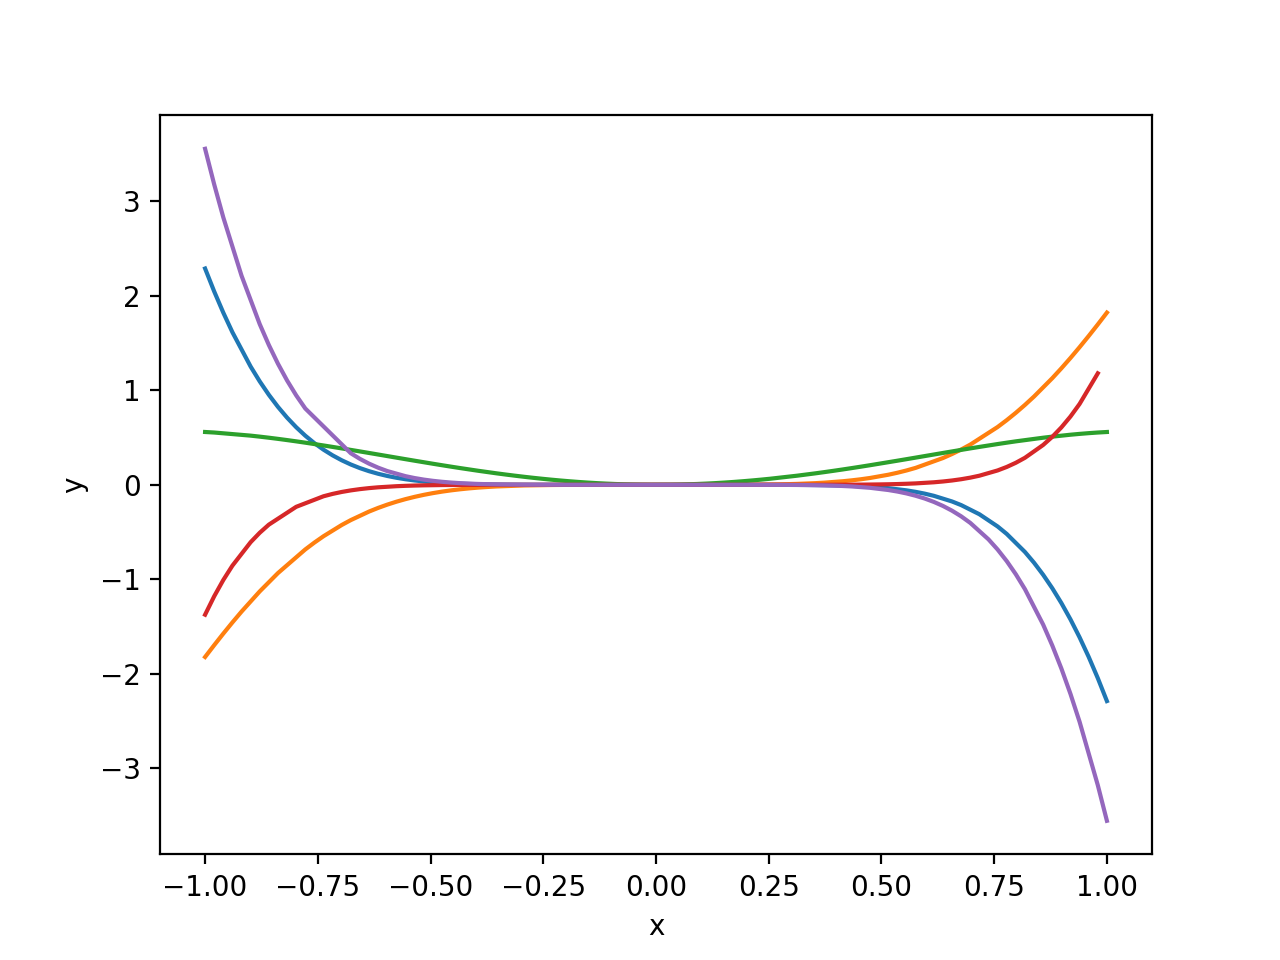

In [12]:
plt.figure()

for i in range(0,25,5):
    x_sample, y_sample = data["states"][i][:80], data["states"][i][80:]

    x_sample, y_sample = zip(*sorted(zip(x_sample,y_sample), key=lambda x:x[0]))

    plt.plot(x_sample, y_sample)

plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [3]:
# keep only winning networks

X, y = [], []

n_networks = len(np.unique(data["actions"]))
n_func = len(data["states"]) // n_networks
print(n_networks, n_func)

for f_i in range(n_func):

    best_network = None
    best_score = -2
    
    for n_i in range(n_networks):

        i = f_i * n_networks + n_i

        score = data["scores"][i]
        if score > best_score:
            best_score = score
            best_network = data["actions"][i]
    
    X.append(data["states"][i])
    y.append(best_network)
    
X = np.array(X)
y = np.array(y)

5 900


In [4]:
# sanity check

for i in range(6):
    print(X[i][:5], y[i])
    
print(np.bincount(y))

[-0.61616162 -0.6969697  -0.97979798  0.81818182  0.29292929] 0
[ 0.83838384  0.23232323  0.75757576 -0.97979798 -0.47474747] 1
[-1.         -0.83838384  0.67676768  0.37373737  0.87878788] 1
[ 0.17171717 -0.85858586  0.91919192 -0.7979798  -0.07070707] 0
[ 0.31313131  0.61616162  0.87878788  0.77777778 -0.95959596] 0
[ 0.37373737 -1.         -0.5959596  -0.67676768  1.        ] 2
[325 288 255  24   8]


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

preprocessor = Pipeline([
    ("minmax", MinMaxScaler()),
    ("std", StandardScaler())
])

X = preprocessor.fit_transform(X)

In [6]:
if len(y.shape) == 1:
    y = tf.keras.utils.to_categorical(y, len(np.unique(y)))

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (900, 160)
y shape:  (900, 5)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.33, 
    random_state=42
)

In [12]:
# Creation of the model

def generate_nn(input_shape, output_shape, nunits=[10, 10], activation=["relu", "relu"]):

    assert len(nunits) == len(activation)

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    

    for i, (nunits_, activation_) in enumerate(zip(nunits, activation)):
        model.add(
            tf.keras.layers.Dense(nunits_, activation=activation_, name=f"layer_{i+1}")
        )

    model.add(tf.keras.layers.Dense(output_shape, activation="softmax"))

    return model

nlayers = 3
config = dict(
    nunits=[100]*nlayers,
    activation=["relu"]*nlayers
)

model = generate_nn(X.shape[1:], y.shape[1], **config)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 160)               640       
_________________________________________________________________
layer_1 (Dense)              (None, 100)               16100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
layer_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
layer_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense (Dense)                (None, 5)                 5

In [13]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)

history = model.fit(X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_data=(X_test, y_test),
    verbose=1
).history

Epoch 1/100
38/38 [==============================] - 1s 7ms/step - loss: 1.7117 - acc: 0.2576 - val_loss: 1.3492 - val_acc: 0.3468
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 1.1190 - acc: 0.4905 - val_loss: 1.2792 - val_acc: 0.3906
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 0.9282 - acc: 0.6169 - val_loss: 1.2751 - val_acc: 0.4007
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 0.8574 - acc: 0.6602 - val_loss: 1.2928 - val_acc: 0.3670
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 0.6818 - acc: 0.7549 - val_loss: 1.3214 - val_acc: 0.4040
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 0.6570 - acc: 0.7707 - val_loss: 1.3793 - val_acc: 0.4074
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 0.5268 - acc: 0.8117 - val_loss: 1.4261 - val_acc: 0.4108
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 0.4303 - a

<IPython.core.display.Javascript object>


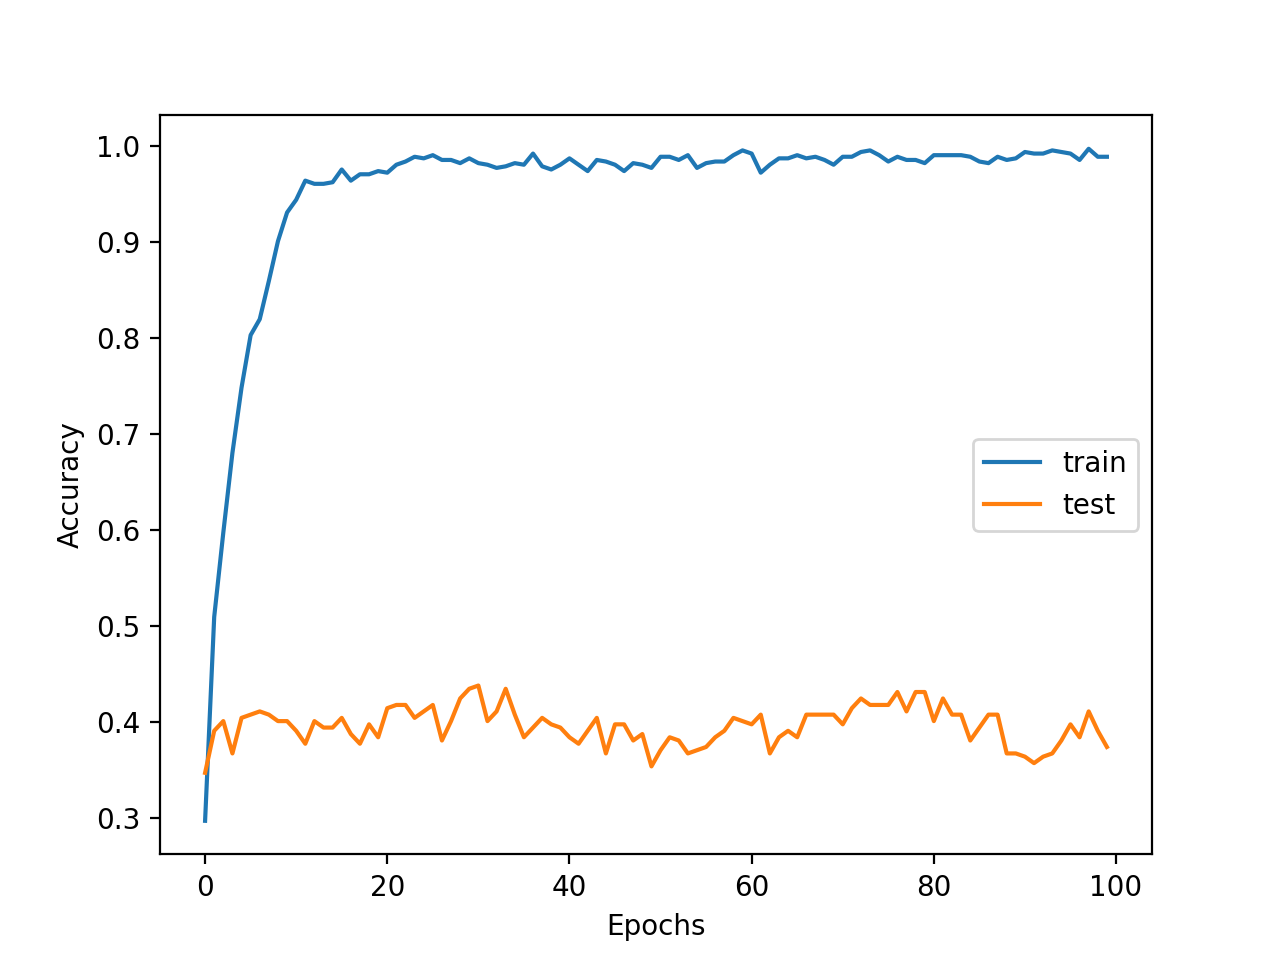

In [14]:
plt.figure()
plt.plot(history["acc"], label="train")
plt.plot(history["val_acc"], label="test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

<IPython.core.display.Javascript object>


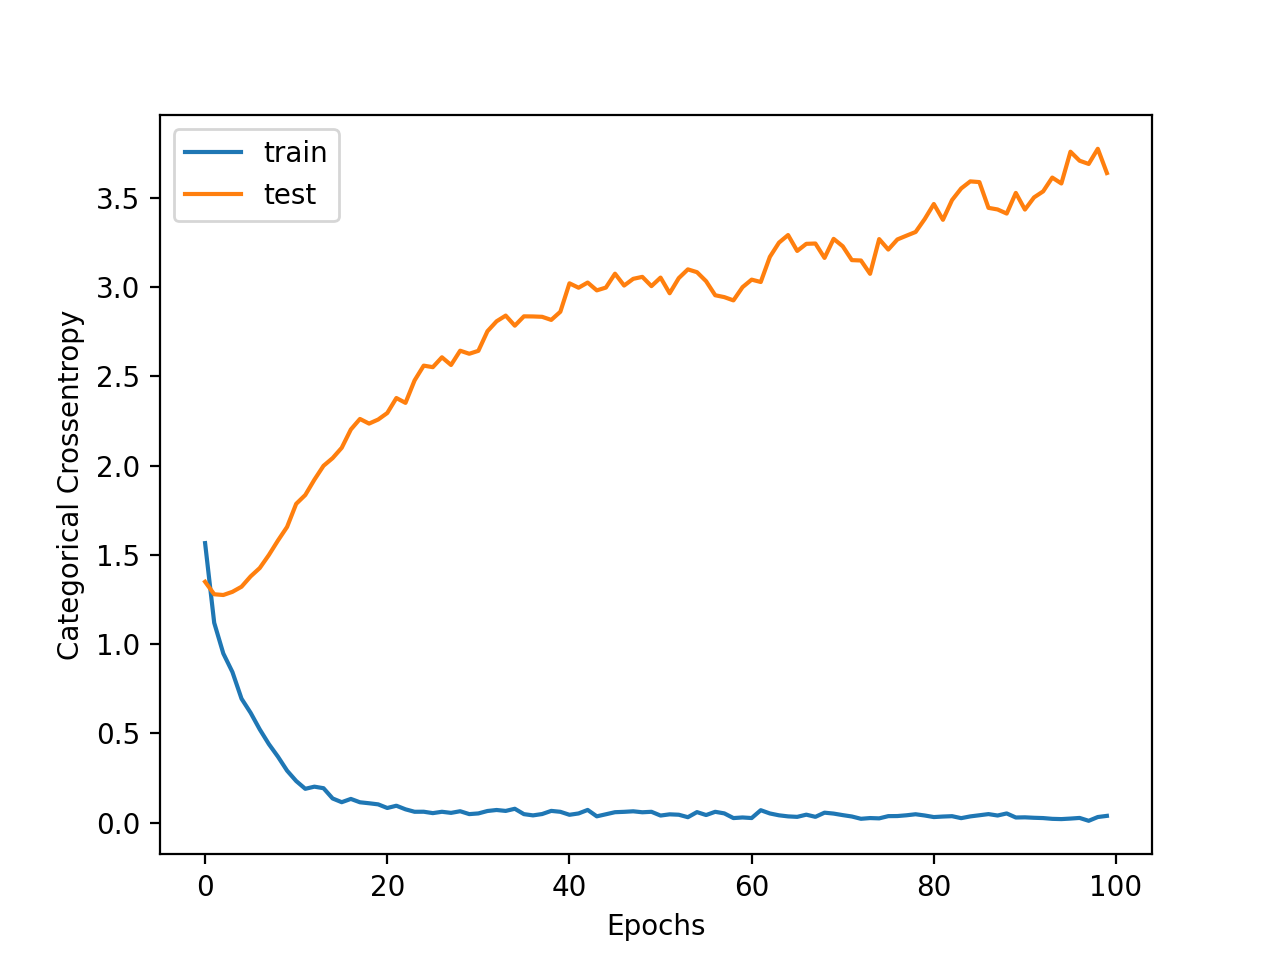

In [15]:
plt.figure()
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="test")

plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")

plt.legend()

plt.show()

## More complex model

In [29]:
def generate_nn_split(input_shape, output_shape, nunits=[10, 10], activation=["relu", "relu"]):

    assert len(nunits) == len(activation)
    
    input_layer = tf.keras.Input(shape=input_shape)
    input_x = input_layer[:,:80]
    input_y = input_layer[:,80:]
    
    def sub_model(out, nunits, activation):
        for i, (nunits_, activation_) in enumerate(zip(nunits, activation)):
            out = tf.keras.layers.Dense(nunits_, activation=activation_)(out)
#             out = tf.keras.layers.Dropout(0.25)(out)
        return out
    
    out_x = sub_model(input_x, nunits, activation)
    out_y = sub_model(input_y, nunits, activation)
    
    in_merged = out_x + out_y
    out_merged = sub_model(in_merged, nunits, activation)
    out = tf.keras.layers.Dense(output_shape, activation="softmax")(out_merged)
      
    model = tf.keras.Model(input_layer, out)

    return model

In [11]:
nlayers = 5
config_nn = dict(
    nunits=[25]*nlayers,
    activation=["swish"]*nlayers
)

model = generate_nn_split(X.shape[1:], y.shape[1], **config_nn)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160)]        0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 80)           0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 80)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 25)           2025        tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

In [9]:
# with augmentation (permutations)

def augment(x, y):
    indexes = tf.range(80, delta=1)
    indexes = tf.random.shuffle(indexes)
    x = tf.concat([tf.gather(x, indexes), tf.gather(x, indexes+80)], axis=0)
    return x, y


def sanity_check():
    
    tf_data = tf.data.Dataset.from_tensor_slices((X,y))
    tf_data = tf_data.map(augment)
    
    for xi, yi in tf_data.as_numpy_iterator():
        print(xi[:5], yi)
        break
    for xi, yi in tf_data.as_numpy_iterator():
        print(xi[:5], yi)
        break
sanity_check()

[-0.47890514 -1.11423224  0.13733957  1.01539029 -1.66743304] [1. 0. 0. 0. 0.]
[ 1.48309806  1.66720434 -1.60748127 -1.19245208 -1.26774015] [1. 0. 0. 0. 0.]


In [54]:
class_weights = compute_class_weight("balanced", classes=np.unique(np.argmax(y, axis=1)), y=np.argmax(y, axis=1))

class_weight = {i:v for i,v in enumerate(class_weights)}

print(class_weight)

{0: 0.5538461538461539, 1: 0.625, 2: 0.7058823529411765, 3: 7.5, 4: 22.5}


In [55]:
# hyperparameters
batch_size = 32
learning_rate = 0.001
optimizer = "rmsprop"
repeat = 20

nlayers = 3
config_nn = dict(
    nunits=[20]*nlayers,
    activation=["swish"]*nlayers
)

# 1. Start a new run
wandb.init(project='offline-rl', entity='deathn0t')

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = learning_rate
config.batch_size = batch_size
config.activation = config_nn["activation"]
config.nunits = config_nn["nunits"]
config.optimizer = optimizer
config.class_weights = class_weights

model = generate_nn_split(X.shape[1:], y.shape[1], **config_nn)

model.summary()

epoch,199
loss,0.50615
acc,0.78574
weighted_acc,0.78574
val_loss,3.8696
val_acc,0.39394
val_weighted_acc,0.39394
_runtime,123
_timestamp,1615481438
_step,199
best_val_loss,1.14476


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
acc,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
weighted_acc,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
val_loss,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
val_acc,▅▅▇▄▇▆█▆█▅▅▆▄▆▅▅▅▅▄▁▄▄▂▃▄▄▂▄▄▃▄▄▄▂▅▅▅▄▃▃
val_weighted_acc,▅▅▇▄▇▆█▆█▅▅▆▄▆▅▅▅▅▄▁▄▄▂▃▄▄▂▄▄▃▄▄▄▂▅▅▅▄▃▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160)]        0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_8 (Sli (None, 80)           0           input_5[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_9 (Sli (None, 80)           0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 20)           1620        tf.__operators__.getitem_8[0][0] 
____________________________________________________________________________________________

In [56]:
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
tf_train = tf_train.shuffle(1000).repeat(repeat)
tf_train = tf_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
tf_train = tf_train.batch(batch_size)
tf_train = tf_train.prefetch(tf.data.AUTOTUNE)

In [57]:
if optimizer == "adam":
    print("adam")
    optimizer_fn = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer == "rmsprop":
    print("rmsprop")
    optimizer_fn = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
else:
    print(optimizer)
    optimizer_fn = optimizer

rmsprop


In [58]:
model.compile(
    optimizer=optimizer_fn,
    loss="categorical_crossentropy",
    metrics=["acc"],
    weighted_metrics=["acc"],
)

history = model.fit(tf_train,
    epochs=200, 
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[WandbCallback()],
    class_weight=class_weight
).history

Epoch 1/200
377/377 [==============================] - 2s 2ms/step - loss: 1.5072 - acc: 0.3533 - weighted_acc: 0.2614 - val_loss: 1.4066 - val_acc: 0.2929 - val_weighted_acc: 0.2929
Epoch 2/200
377/377 [==============================] - 1s 2ms/step - loss: 1.3512 - acc: 0.2994 - weighted_acc: 0.3811 - val_loss: 1.3956 - val_acc: 0.3064 - val_weighted_acc: 0.3064
Epoch 3/200
377/377 [==============================] - 1s 1ms/step - loss: 1.2837 - acc: 0.3084 - weighted_acc: 0.4068 - val_loss: 1.4239 - val_acc: 0.2963 - val_weighted_acc: 0.2963
Epoch 4/200
377/377 [==============================] - 1s 1ms/step - loss: 1.3015 - acc: 0.3083 - weighted_acc: 0.4146 - val_loss: 1.4215 - val_acc: 0.3199 - val_weighted_acc: 0.3199
Epoch 5/200
377/377 [==============================] - 1s 1ms/step - loss: 1.2825 - acc: 0.3134 - weighted_acc: 0.4060 - val_loss: 1.4173 - val_acc: 0.2963 - val_weighted_acc: 0.2963
Epoch 6/200
377/377 [==============================] - 1s 1ms/step - loss: 1.2488 - a

Epoch 44/200
377/377 [==============================] - 1s 1ms/step - loss: 1.0247 - acc: 0.3481 - weighted_acc: 0.5197 - val_loss: 1.4048 - val_acc: 0.3266 - val_weighted_acc: 0.3266
Epoch 45/200
377/377 [==============================] - 0s 1ms/step - loss: 1.0398 - acc: 0.3400 - weighted_acc: 0.5155 - val_loss: 1.4728 - val_acc: 0.2963 - val_weighted_acc: 0.2963
Epoch 46/200
377/377 [==============================] - 1s 1ms/step - loss: 1.0259 - acc: 0.3523 - weighted_acc: 0.5403 - val_loss: 1.5084 - val_acc: 0.3098 - val_weighted_acc: 0.3098
Epoch 47/200
377/377 [==============================] - 1s 2ms/step - loss: 1.0459 - acc: 0.3630 - weighted_acc: 0.5190 - val_loss: 1.5039 - val_acc: 0.3131 - val_weighted_acc: 0.3131
Epoch 48/200
377/377 [==============================] - 1s 1ms/step - loss: 1.0320 - acc: 0.3677 - weighted_acc: 0.5320 - val_loss: 1.4453 - val_acc: 0.3300 - val_weighted_acc: 0.3300
Epoch 49/200
377/377 [==============================] - 1s 1ms/step - loss: 0.99

Epoch 132/200
377/377 [==============================] - 1s 2ms/step - loss: 0.8559 - acc: 0.4714 - weighted_acc: 0.6042 - val_loss: 1.8400 - val_acc: 0.3333 - val_weighted_acc: 0.3333
Epoch 133/200
377/377 [==============================] - 1s 2ms/step - loss: 0.8637 - acc: 0.4758 - weighted_acc: 0.6078 - val_loss: 1.9531 - val_acc: 0.3199 - val_weighted_acc: 0.3199
Epoch 134/200
377/377 [==============================] - 1s 2ms/step - loss: 0.9038 - acc: 0.4674 - weighted_acc: 0.6039 - val_loss: 1.7976 - val_acc: 0.3333 - val_weighted_acc: 0.3333
Epoch 135/200
377/377 [==============================] - 1s 2ms/step - loss: 0.8513 - acc: 0.4659 - weighted_acc: 0.6111 - val_loss: 1.9034 - val_acc: 0.2929 - val_weighted_acc: 0.2929
Epoch 136/200
377/377 [==============================] - ETA: 0s - loss: 0.9024 - acc: 0.4649 - weighted_acc: 0.60 - 1s 2ms/step - loss: 0.9022 - acc: 0.4649 - weighted_acc: 0.6041 - val_loss: 1.9548 - val_acc: 0.2828 - val_weighted_acc: 0.2828
Epoch 137/200
3

Epoch 176/200
377/377 [==============================] - 1s 2ms/step - loss: 0.9140 - acc: 0.4833 - weighted_acc: 0.6169 - val_loss: 2.0239 - val_acc: 0.3636 - val_weighted_acc: 0.3636
Epoch 177/200
377/377 [==============================] - 1s 2ms/step - loss: 0.8332 - acc: 0.4892 - weighted_acc: 0.6303 - val_loss: 2.0786 - val_acc: 0.3636 - val_weighted_acc: 0.3636
Epoch 178/200
377/377 [==============================] - 1s 2ms/step - loss: 0.8819 - acc: 0.4722 - weighted_acc: 0.6156 - val_loss: 1.9629 - val_acc: 0.3232 - val_weighted_acc: 0.3232
Epoch 179/200
377/377 [==============================] - 1s 2ms/step - loss: 0.8445 - acc: 0.4760 - weighted_acc: 0.6102 - val_loss: 2.1927 - val_acc: 0.2761 - val_weighted_acc: 0.2761
Epoch 180/200
377/377 [==============================] - 1s 2ms/step - loss: 0.8367 - acc: 0.4827 - weighted_acc: 0.6389 - val_loss: 2.1817 - val_acc: 0.3098 - val_weighted_acc: 0.3098
Epoch 181/200
377/377 [==============================] - 1s 2ms/step - loss

<IPython.core.display.Javascript object>


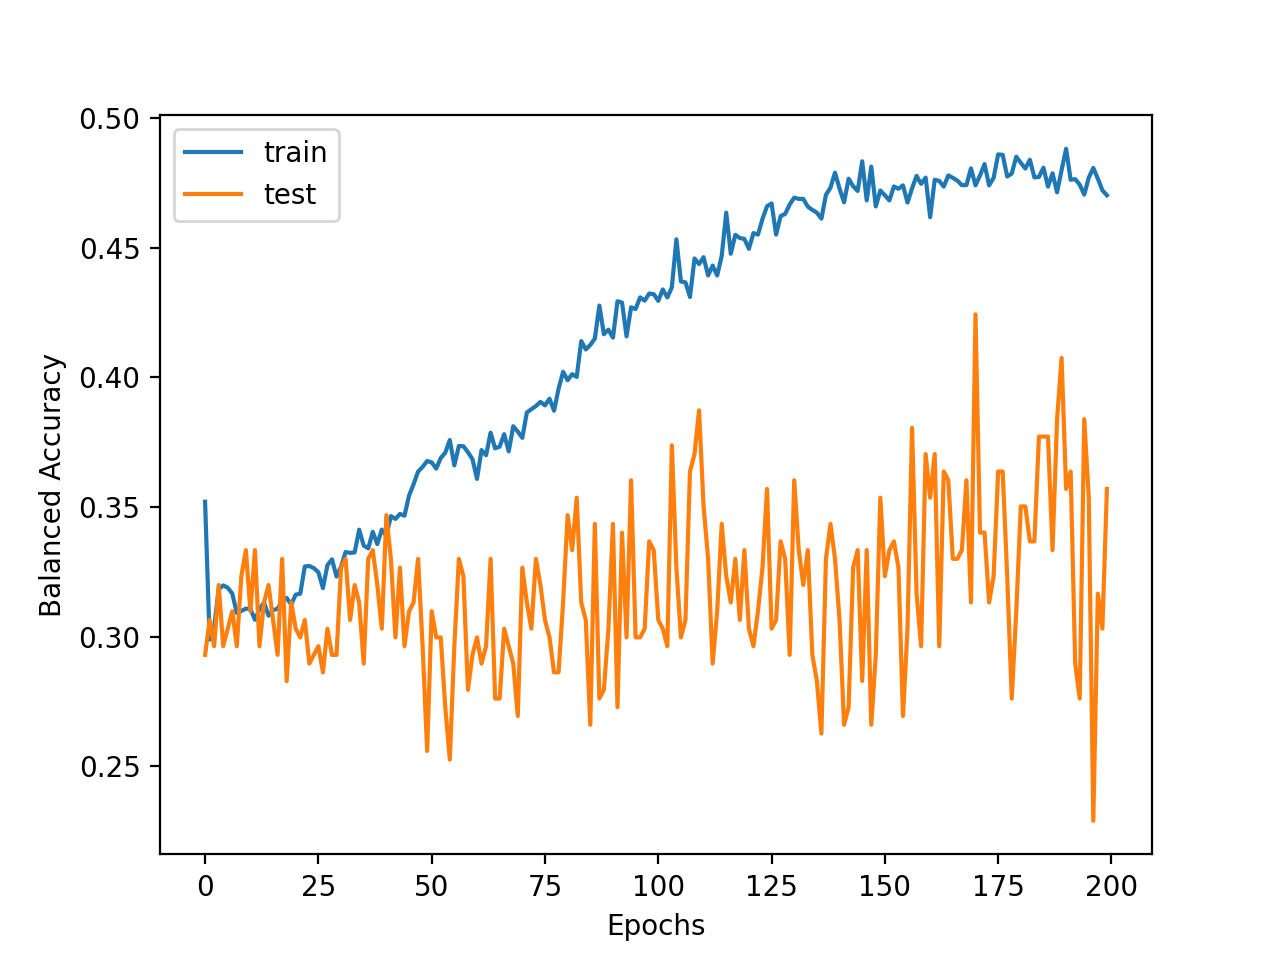

In [59]:
plt.figure()
plt.plot(history["acc"], label="train")
plt.plot(history["val_acc"], label="test")

plt.xlabel("Epochs")
plt.ylabel("Balanced Accuracy")

plt.legend()

plt.show()

In [60]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)
acc = accuracy_score(y_true, y_pred)
print(f"Training accuracy: {acc:.3f}")

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
acc = accuracy_score(y_true, y_pred)


print(f"Validation accuracy: {acc:.3f}")

Training accuracy: 0.483
Validation accuracy: 0.357


In [72]:
Xr, yr = [], []

n_networks = len(np.unique(data["actions"]))
n_func = len(data["states"]) // n_networks
print(n_networks, n_func)

for f_i in range(n_func):

    scores = []
    for n_i in range(n_networks):

        i = f_i * n_networks + n_i
        scores.append(data["scores"][i])
    
    Xr.append(data["states"][i])
    yr.append(scores)
    
Xr = np.array(Xr)
yr = np.array(yr)

Xr = preprocessor.transform(Xr)

print(np.shape(Xr))
print(np.shape(yr))

5 900
(900, 160)
(900, 5)


In [75]:
# max reward
max_reward = np.sum(np.max(yr,axis=1))

# behavioral cloning reward
y_pred = model.predict(Xr)
y_pred = np.argmax(y_pred, axis=1)
y_pred = np.array([yr[i,j] for i,j in enumerate(y_pred)])
bc_reward = np.sum(y_pred)

# random action
n = 10
random_reward_uniform = 0
for i in range(n):
    y_pred = np.random.randint(5,size=900) # uniform
    y_pred = np.array([yr[i,j] for i,j in enumerate(y_pred)])
    random_reward_uniform += np.sum(y_pred)
random_reward_uniform /= n

p = np.sum(y, axis=0)/np.sum(y)
random_reward_prior = 0
for i in range(n):
    y_pred = np.random.choice(5, 900, p=p) # using a prior
    y_pred = np.array([yr[i,j] for i,j in enumerate(y_pred)])
    random_reward_prior += np.sum(y_pred)
random_reward_prior /= n

print("max reward: ", max_reward)
print("bc reward: ", bc_reward)
print("random(uniform) reward: ", random_reward_uniform)
print("random(prior) reward: ", random_reward_prior)

max reward:  794.729732140788
bc reward:  403.7333807055741
random(uniform) reward:  218.1316448512613
random(prior) reward:  396.2309660729525
